# Replica Exchange Simulation to Compute Protonation Free Energy of a Lys Residue in Vacuum

## Introduction

### In this tutorial, we are going to use Hamiltonian replica exchange simulation to compute protonation free energy of a Lys residue in vacuum.

### Below is the Lys residue we are going to simulate. $CH_{3}CO-$ and $CH_{3}NH-$ groups are patched at the N- and C-termini, respectively. We set up a hybrid system here, where both $\color{blue}{\text {protonated state (state 1)}}$ and $\color{red}{\text{unprotonated state (state 2)}}$ are present. Potential energy of the system is as follows:

$$
U=U_{x_0,x_0}+\lambda (U_{x_1,x_1}+U_{x_0,x_1})+(1-\lambda)(U_{x_2,x_2}+U_{x_0,x_2})
$$



<img src="fig/fig2-lys.pdf" width=300 height=300/>

### In a replica exchange simulation, we have multiple <b>replicas</b> of the same system simulated under different <b>conditions</b>. Periodically, exchange will be attempted between neighboring replicas. To obtain correct distribution, the exchange ratio is determined accoriding to the Metropolois criterion. In this tutorial, different conditions correspond to different $\lambda$ values in the above equation.



<img src="fig/fig1-rep-ex.pdf" width=600 height=500/>

## Prerequisite

### To run this tutorial, we need to compile CHARMM $\color {pink} {\text {without MPI}}$ (having ```--without-mpi``` in configure). Also, this tutorial uses python module mpi4py (for replica exchange) and FastMBAR (for free energy calculations), which can be installed using pip.

## How to run this script (non-interactively)

### Here we are going to run 8 replicas using 8 processes

```
mpirun -np 8 --quiet python rep_ex_amino_acid.py 8

```

## Explanation of the script

### As always, load the following pyCHARMM modules at the beginning. For this tutorial, we also need mpi4py to perform replica exchange and FastMBAR for free energy calculations.

```

from mpi4py import MPI
import FastMBAR

import os
import sys
import subprocess
import numpy as np
import pandas as pd

import pycharmm
import pycharmm.read as read
import pycharmm.lingo as lingo
import pycharmm.generate as gen
import pycharmm.settings as settings
import pycharmm.write as write
import pycharmm.nbonds as nbonds
import pycharmm.ic as ic
import pycharmm.coor as coor
import pycharmm.energy as energy
import pycharmm.dynamics as dyn
import pycharmm.minimize as minimize
import pycharmm.crystal as crystal
import pycharmm.select as select
import pycharmm.image as image
import pycharmm.psf as psf
import pycharmm.param as param
import pycharmm.cons_harm as cons_harm
import pycharmm.cons_fix as cons_fix
import pycharmm.shake as shake
import pycharmm.scalar as scalar
import pycharmm.charmm_file as charmm_file
```

### We first define some variables used in our simulation, including number of $\lambda$ windows/replicas, simulation temperature, number of replica exchange cycles, number of steps per cycle, etc.

```
# user defined variables
nl_chem=int(sys.argv[1]) # number of windows in lambda_chem
tsim=298.15              # simulation temperature
ncycles=1000             # number of cycles
nsteps_per_cyc=1000      # number of steps per cycle 

# residue name and segment id specific to this system
comp='lys'
segid='PROT'

# if we find that additional simulation time is needed after the first run, 
# we can restart/continue our simulation by chaning variable itt to 2
itt=1                    # run index
ittm1=itt-1              # index of previous run

# for free energy calculation, we need to recompute energies for dcd trajectories.
# if we saved dcd too frequently and would like to reduce the frequency in energy
# calculations, we could increase variable skip_dcd.
skip_dcd=1

# boltzmann constant and inverse temperature 
kB=0.0019872042586408316 # kcal/mol/K
beta=1/kB/tsim


```

### The following script is for MPI setup. In this tutorial, the number of $\lambda$ windows is equal to the number of processes.
```
# mpi setup
comm=MPI.COMM_WORLD
nproc=comm.Get_size()
rank=comm.Get_rank()
repl_id=rank

```

### Set up directories for topology/parameter files, working directory, and output directory
```
# directories
param_dir='toppar'
wrk_dir='.'
out_dir='aa'+str(rank)

```

### Speicify file names for input pdb, psf files, and output files
```
# input and output files
inp_psf_fn=wrk_dir+'/'+comp+'.psf'
inp_pdb_fn=wrk_dir+'/'+comp+'.pdb'
inp_box_fn=wrk_dir+'/box_size.dat'
dcd_fn=out_dir+'/dcd/prod'+str(itt)+'.dcd'
rst_fn=out_dir+'/res/prod'+str(itt)+'.res'
rpr_fn=out_dir+'/res/prod'+str(ittm1)+'.res'
pdb_fn=out_dir+'/pdb/prod'+str(itt)+'.pdb'
log_fn=out_dir+'/out/prod'+str(itt)+'.out'
exc_fn=out_dir+'/exc/exch'+str(itt)+'.dat'
his_fn=out_dir+'/his/cond_his'+str(itt)+'.dat'
cnd_fn=out_dir+'/../cond.dat'
exch_all_fn=out_dir+'/../exchange-all-'+str(itt)+'.dat'
exch_all_pre_fn=out_dir+'/../exchange-all-'+str(ittm1)+'.dat'
ratio_fn=out_dir+'/../ratio-'+str(itt)+'.dat'
```

### $\lambda$ values are linearly spaced here. We can change it to more advanced $\lambda$ schedule here if needed.
```
# lambda_chem
l_g='{0:.4f}'.format(1/(nl_chem-1)*repl_id)


```

### File units of charmm log file, dcd file, and restart files
```
# file units
log_unit=30
dcd_unit=40
rst_unit=50  # unit for current restart file
rpr_unit=70  # unit for previous restart file
```


### Create directories for output files

```
# create directories
os.system('mkdir -p '+out_dir+'/dcd')
os.system('mkdir -p '+out_dir+'/res')
os.system('mkdir -p '+out_dir+'/pdb')
os.system('mkdir -p '+out_dir+'/out')
os.system('mkdir -p '+out_dir+'/exc')
os.system('mkdir -p '+out_dir+'/his')

```

### Conditions ($\lambda$ values here) used in replica exchange
```
def write_cond_file():
    ## save the conditions to a file
    sendbuf=np.array([float(l_g)],dtype='f')
    recvbuf=None
    if rank==0:
       recvbuf = np.empty([nproc, 1], dtype='f')
    comm.Gather(sendbuf,recvbuf,root=0)
    if rank==0:
       np.savetxt(cnd_fn,recvbuf,fmt='%.4f')
    comm.barrier()
    # broadcast condition array
    if rank==0:
        cond_array=recvbuf
    else:
        cond_array=np.empty([nproc, 1], dtype='f')
    comm.Bcast(cond_array, root=0)
    return cond_array

def get_latest_lmd(cond_arr):
    exch_all_pre=np.loadtxt(exch_all_pre_fn,usecols=(9),dtype=int)
    repid_new=exch_all_pre[-1*nproc:]-1
    l='{0:.4f}'.format(cond_arr[repid_new==rank][0][0])
    condid=np.where(repid_new==rank)[0][0]
    #print(rank+1,intra,inter,condid)
    return l,condid


cond_arr=write_cond_file()
if itt >= 2:
       l,condid=get_latest_lmd(cond_arr)
else:
       condid=rank
       l=l_g
```

### Specify charmm output file

```
clog=charmm_file.CharmmFile(file_name=log_fn,file_unit=log_unit,read_only=False,formatted=True)
lingo.charmm_script('outu '+str(log_unit))
```

### Read topology and parameter files. The topology file is special here since we have a hybrid system, contatining both protonated and unprotonated form of Lys
```
read.rtf(param_dir+'/top_all36_prot_hedi_xrliu.rtf')
read.prm(param_dir+'/par_all36m_prot.prm',flex=True)
```


### Read psf and pdb file of the initial structure
```
read.psf_card(inp_psf_fn)
read.pdb(inp_pdb_fn,resid=True)
```

### Set up periodic boundary condition
```
size=np.loadtxt(inp_box_fn,usecols=(0))
crystal.define_cubic(size)
crystal.build(12)
# shift box center to origin
pos=coor.get_positions()
coor.set_positions(pos-size*0.5)
offset=0
image.setup_segment(offset,offset,offset,segid)
# write coordinates
write.coor_pdb(out_dir+'/init.pdb')

```

### Define substituents at a given site: here the protonated state and the unprotonated state. Then use "BLOCK" function in CHARMM to make them not interact with each other

```

def define_sub(aa,ires):
    '''
    define substituents
    '''
    resn=aa.upper()
    resid=str(ires)
    atom_list=titr_grp(resn)
    sele_w=~pycharmm.SelectAtoms(select_all=True)
    sele_m=~pycharmm.SelectAtoms(select_all=True)
    sele_p=~pycharmm.SelectAtoms(select_all=True)
    sele_u=~pycharmm.SelectAtoms(select_all=True)
    for name in atom_list:
        sele_w = sele_w | pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=name+'W')
        sele_m = sele_m | pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=name+'M')
        sele_p = sele_p | pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=name+'P')
        sele_u = sele_u | pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=resid,atom_type=name+'U')
    sele_w.store('site{}{}subW'.format(resn,resid))
    sele_m.store('site{}{}subM'.format(resn,resid))
    sele_p.store('site{}{}subP'.format(resn,resid))
    sele_u.store('site{}{}subU'.format(resn,resid))

class set_block:
    '''
    set up block for simulation
    '''
    def __init__(self,aa='',ires='1',nstates='2',lmd=''):
        self.resn=aa.upper()
        self.resid=str(ires)
        self.nstat=int(nstates)
        self.lmd=float(lmd)
    def run(self):
        self.set_name()
        self.reset()
        self.call()
    def set_name(self):
        sele_name_w='site%s%ssubW'%(self.resn,self.resid)
        sele_name_m='site%s%ssubM'%(self.resn,self.resid)
        sele_name_p='site%s%ssubP'%(self.resn,self.resid)
        sele_name_u='site%s%ssubU'%(self.resn,self.resid)
        if self.resn == 'ASP' or self.resn == 'GLU':
           self.sele_name=[sele_name_w,sele_name_m,sele_name_p]
        elif self.resn == 'HSD':
           self.sele_name=[sele_name_w,sele_name_u]
        elif self.resn == 'HSE':
           self.sele_name=[sele_name_w,sele_name_m]
        elif self.resn == 'LYS':
           self.sele_name=[sele_name_w,sele_name_m]
        elif self.resn == 'HSP':
           self.sele_name=[sele_name_w,sele_name_u,sele_name_m]
    def reset(self):
        lingo.charmm_script('''
              BLOCK %s
                    clear 
              END
        '''%(self.nstat+1))
    def call(self):
        excl_list=''
        for i in range(0,self.nstat):
            for j in range(i+1,self.nstat):
                excl_list=excl_list+str(i+2)+' '+str(j+2)+' '
        lingo.charmm_script('''
              BLOCK {nblk}
                    call 2 sele {sele1} end
                    call 3 sele {sele2} end

                    coef 1 1 1.0
                    coef 1 2 {lmbd1}
                    coef 1 3 {lmbd2}

                    coef 2 2 {lmbd1}
                    coef 2 3 0.0

                    coef 3 3 {lmbd2}

                    excl {excl}

                    rmla bond thet impr
                    msma
              END
        '''.format(nblk=self.nstat+1,
                   sele1=self.sele_name[0],
                   sele2=self.sele_name[1],
                   lmbd1=self.lmd,
                   lmbd2=1.0-self.lmd,
                   excl=excl_list))
    
        
define_sub(comp,ires=1)

blk=set_block(comp,ires=1,nstates='2',lmd=l)
blk.run()
```

### Set up nonbonded interactions

```
nbond={'elec': True,
       'atom': True,
       'cdie': True,
       'fswitch': True,
       'eps': 1,
       'vdw': True,
       'vatom': True,
       'vfswitch': True,
       'cutnb': 14,
       'cutim': 14,
       'ctofnb': 12,
       'ctonnb': 10,
       'ewald': False
      }
nb_nopme=pycharmm.NonBondedScript(**nbond)
nb_nopme.run()
```

### Restrain the conformations between the protonated form and unprotonated form

```

class resd_restrain:
    '''
    restrain all or heavy atoms between analogous groups of the 2 or 3 protonation states using resd restraint.
    dynamics doesn't work if analogous atoms are on top of each other.
    '''
    def __init__(self,aa='',ires='',heavy=True):
        self.heavy=heavy
        self.resn=aa.upper()
        self.resid=str(ires)
    def run(self):
        self.reset()
        self.restrain()
        self.show()
    def reset(self):
        lingo.charmm_script('RESD reset')
    def resd(self,name):
        sel_w=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=self.resid,atom_type=name+'W')
        sel_m=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=self.resid,atom_type=name+'M')
        sel_p=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=self.resid,atom_type=name+'P')
        sel_u=pycharmm.SelectAtoms().by_res_and_type(seg_id=segid,res_id=self.resid,atom_type=name+'U')
        w=sel_w.get_n_selected()
        m=sel_m.get_n_selected()
        p=sel_p.get_n_selected()
        u=sel_u.get_n_selected()
        if w==1 and m==1:
           lingo.charmm_script('resd kval 100 rval 0.0 eval 2 ival 1 1.0 %s %s %s %s %s %s'%
                               (segid,self.resid,name+'W',segid,self.resid,name+'M'))
        if w==1 and p==1:
           lingo.charmm_script('resd kval 100 rval 0.0 eval 2 ival 1 1.0 %s %s %s %s %s %s'%
                               (segid,self.resid,name+'W',segid,self.resid,name+'P'))
        if w==1 and u==1:
           lingo.charmm_script('resd kval 100 rval 0.0 eval 2 ival 1 1.0 %s %s %s %s %s %s'%
                               (segid,self.resid,name+'W',segid,self.resid,name+'U'))
    def restrain(self):
        atom_list=titr_grp(self.resn)
        for atom_name in atom_list:
            if self.heavy==True:  # restrain heavy atoms
               if atom_name[0]!='H':
                  self.resd(atom_name)
            else:                 # restrain all atoms
               self.resd(atom_name)
    def show(self):
        lingo.charmm_script('print resdistances')
        energy.show()
        
        
        
restrain=resd_restrain(comp,ires=1)
restrain.run()
```

### If this the first run, do a quick energy minimization
```
if itt == 1:
    minimize.run_sd(nstep=50,nprint=10,tolenr=1e-3,tolgrd=1e-3)
    energy.show()
    # write coordinates
    write.coor_pdb(out_dir+'/mini.pdb')
```

#### Set up SHAKE and fbeta before we run dynamics
```
lingo.charmm_script('''
          faster on
''')
shake.on(bonh=True, fast=True, tol=1e-7)
n = psf.get_natom()
scalar.set_fbetas([1.0] * n)
```



### Run replica exchange simulations

```
dyn_dict={
    'leap': True,
    'verlet': False,
    'cpt': False,
    'new': False,
    'langevin': True,
    'omm': False,
    'start': True,
    'timestep': 0.002,
    'nstep': nsteps_per_cyc,
    'nsavc': 0,
    'nsavv': 0,
    'nsavl': 0,      # frequency for saving lambda values in lamda-dynamics
    'nprint': nsteps_per_cyc, # Frequency to write to output
    'iprfrq': nsteps_per_cyc, # Frequency to calculate averages
    'isvfrq': nsteps_per_cyc, # Frequency to save restart file
    'ntrfrq': 5000,
    'inbfrq':-1,
    'ihbfrq':0,
    'ilbfrq':0,
    'imgfrq':-1,
    'iunrea':-1,
    'iunwri':rst_unit,
    'iuncrd':-1,
    'iunldm':-1,
    'firstt': tsim,
    'finalt': tsim,
    'tstruct': tsim,
    'tbath': tsim,
    'iasors': 1, # assign velocities
    'iasvel': 1, # method for assignment of velocities during heating & equil when IASORS is nonzero.
                 # This option also controls the initial assignment of velocities 
    'iscale': 0, # not scale velocities on a restart
    'scale': 1,  # scaling factor for velocity scaling
    'ichecw': 0, # not check temperature
    'echeck': -1 # not check energy
}


...


rex=rep_ex(ncycle=ncycles,condid=condid,lmd=l,conditions=cond_arr)
rex.run()
```

### In the above replica exchange simulations, trajecotries are saved based on replica instead of condition. We need to unmix dcds here

```
comm.barrier()
rex.trj_unmixing()
```

### To obtain exchange accpetance ratio, we can do 

```
comm.barrier()
rex.accept_ratio()

```


### To compute free energy free energy profile as a function of $\lambda$, we need to recompute energies for the unmixed trajectory and then use MBAR 

```
def calc_ener(cond_array):
    dcd_cond_fn='cond'+str(rank)+'/dcd/prod'+str(itt)+'.dcd'
    os.system('mkdir -p cond'+str(rank)+'/ener')
    for i in range(0,nproc):
        l_new=cond_array[i][0]
        blk=set_block(comp,ires=1,nstates='2',lmd=l_new)
        blk.run()
        #print(l_new)
        ener_fn='cond'+str(rank)+'/ener/ener'+str(itt)+'-'+str(l_new)+'.dat'
        dcd_cond=charmm_file.CharmmFile(file_name=dcd_cond_fn,file_unit=7,read_only=True,formatted=False)
        lingo.charmm_script('traj query unit 7')
        nf=lingo.get_energy_value('NFILE')
        skip=lingo.get_energy_value('SKIP')
        lingo.charmm_script('traj firstu 7 nunit 1 skip %s'%(skip*skip_dcd))
        ener=open(ener_fn,'w',buffering=1)
        settings.set_verbosity(0)
        for iframe in range(0,int(nf/skip_dcd)):
            lingo.charmm_script('''
                       traj read
                       energy
            ''')
            e=lingo.get_energy_value('ENER')
            ener.write('%7i %13.4f\n'%(iframe,e))
        ener.close()
        dcd_cond.close()

def mbar(combine,cond_array):
    if rank==0:
       if combine==True:
          excl=10
          configs=int(itt*ncycles/skip_dcd)-excl
          beg=1
       else:
          excl=10
          configs=int(ncycles/skip_dcd)-excl
          beg=itt
       ener=np.zeros((nproc,configs,nproc), dtype = float)
       for i in range(0,nproc):
           # protein calc energies loaded in steps
           for step in range(0,nproc):
               l_new=cond_array[step][0]
               #fileName = "cond"+str(i)+"/ener/ener-"+str(l_new)+".dat"
               #tmp = np.loadtxt(fileName,dtype=float,usecols=(1),skiprows=0,max_rows=configs)
               for ii in range(beg,itt+1):
                   fileName = "cond"+str(i)+"/ener/ener"+str(ii)+"-"+str(l_new)+".dat"
                   tmpi = np.loadtxt(fileName,dtype=float,usecols=(1),skiprows=0,max_rows=ncycles)
                   if ii>beg:
                      tmp=np.concatenate((tmp,tmpi))
                   elif ii==beg:
                      tmp=tmpi
               if step > 0:
                   tmp2 = np.column_stack((tmp2,tmp))
               else:
                   tmp2=np.copy(tmp)
           ener[i,:,:] = tmp2[excl:,:]

       # calculate free energy difference using FastMBAR
       N_k = [configs for i in range(nproc)]
       N_k = np.asarray(N_k)
       tmp = ener.reshape((-1,nproc))
       u_kn = tmp.T * beta
       print(u_kn)
       print(N_k)
       mb = FastMBAR.FastMBAR(energy = u_kn, num_conf = N_k, cuda = False, bootstrap=True, verbose=True)
       F = mb.F
       F_std = mb.F_std
       print("F is:",F)
       print("F_std is:",F_std)

       # write to disk
       fp=open('mbar.out','w')
       for i in range(len(F)):
           # convert reduced energies back to regular energies
           fp.write("%.6f %.6f\n" % (F[i]/beta,F_std[i]/beta))
       fp.close()



calc_ener(cond_arr)
comm.barrier()
mbar(combine=True,cond_array=cond_arr)
comm.barrier()


```

## Some technical details about replica exchange implementation

### In each replica exchange cycle, we first run MD simulation ```nvt(i)```, write the last snapshot to a dcd file ```self.write_trj(i)```. At this point, a given processor/replica only knows current condition ID and the corresponding $\lambda$ value, not those of other processors.



```
      def run(self):
          self.open_files()
          for i in range(0,self.nrun):
              
              nvt(i)
              self.write_trj(i)
              self.cond_data=self.gather_condid(i)
              self.lmd_new=self.swap_neighbor(i)
              
              self.get_ener_new()
              self.metropolis()
              
              self.write_exch_all(i)
              self.update_cond()
          self.close_files()

```




### In order to perform replica exchange, each processor should know condition IDs of other processors. ```gather_condid(i)``` is for this purpose. The returned ```data``` is a list of condition IDs, and index of this list is ```rank```.


```
      def gather_condid(self,run):
          data=self.cond_id
          data=comm.gather(data,root=0)
          data=comm.bcast(data,root=0)
          #print('run',run,'rank',rank,data)
          return data


```


### We next could recompute energy of the latest snapshot assumming $\lambda$ is changed to a new value $\lambda_{new}$. 
### Function ```swap_neighbor(i)``` determines what $\lambda_{new}$ should be. It also finds the neighboring replica/rank whose $\lambda$ is $\lambda_{new}$ before exchange. 
### Function ```get_ener_new``` recompute energy of the lastest frame when condition is changed to $\lambda_{new}$.
```
def swap_neighbor(self,run):
    self.new_cond_id=get_neighbor(self.cond_id,run)
    self.neighbor_repl_id=self.cond_data.index(self.new_cond_id)
    lmd=self.cond_array[self.new_cond_id][0]
    return lmd

def get_ener_new(self):
    blk=set_block(comp,ires='1',nstates='2',lmd=self.lmd_new)
    blk.run()
    energy.show()
    self.ener_in=lingo.get_energy_value('ENER')
    self.exch.write('%2d %15f '%(self.neighbor_repl_id,self.ener_in))
    comm.barrier()

```

### Once we get energies under conditions $\lambda$ and $\lambda_{new}$, we can use Metropolis criterion to determine if the exchange will be accepted. This is the purpose of ```metropolis()```. Here we need to use mpi to communicate energies between two neighboring conditions. Also, after decision is made, it needs to be sent to both processors.

```
      def metropolis(self):
          self.Accept=True
          self.prob=1
          self.rand=0
          if self.cond_id > self.new_cond_id:
             comm.send(self.ener_im, dest=self.neighbor_repl_id, tag=11)
             comm.send(self.ener_in, dest=self.neighbor_repl_id, tag=12)
          elif self.cond_id < self.new_cond_id:
             ener_jn=comm.recv(source=self.neighbor_repl_id,tag=11)
             ener_jm=comm.recv(source=self.neighbor_repl_id,tag=12)
             delta=-1*beta*(ener_jm+self.ener_in-self.ener_im-ener_jn)
             
             if delta<0:
                self.prob=np.exp(delta)
                #print('prob ',self.prob)
                self.rand=np.random.uniform(low=0.0, high=1.0)
                if self.prob < self.rand:
                   self.Accept=False
                   #print('reject')
          comm.barrier()
          if self.cond_id < self.new_cond_id:
             comm.send(self.Accept,dest=self.neighbor_repl_id,tag=13)
          elif self.cond_id > self.new_cond_id:
             self.Accept=comm.recv(source=self.neighbor_repl_id,tag=13)
          comm.barrier()
          self.exch.write('%5f %5f %5s '%(self.prob,self.rand,str(self.Accept)[0]))

```


### For a given replica/rank, after we determine if the exchange is accepted or not, we write all exchange information to a file (using function```write_exch_all(i)```). This file will be used to do trjectory unmixing later. Also, we need to update BLOCK command accordingly (using function ```update_cond()```)

## Check results

### File ```cnd_fn``` contains condition information (i.e., $\lambda$ here)

In [1]:
!cat cond.dat

0.0000
0.1429
0.2857
0.4286
0.5714
0.7143
0.8571
1.0000


### Directories ```out_dir``` (aa* here) contain dcd files, charmm output file, etc, for each replica. 
### Directories cond* contain dcd files, recomputed energies for each condition.


In [2]:
!ls .

aa0                     cond.dat                exchange-all-1.dat
aa1                     cond0                   fig
aa2                     cond1                   lys.pdb
aa3                     cond2                   lys.psf
aa4                     cond3                   mbar.out
aa5                     cond4                   ratio-1.dat
aa6                     cond5                   rep_ex_amino_acid.ipynb
aa7                     cond6                   rep_ex_amino_acid.py
box_size.dat            cond7                   toppar


In [3]:
!ls aa0 cond0

aa0:
dcd      exc      his      init.pdb mini.pdb out      pdb      res

cond0:
dcd  ener


### File ```ratio_fn``` (ratio-1.dat here) has exchange ratio for the current run.

In [4]:
! cat ratio-1.dat

0.000000 1.000000 332.000000 500.000000 0.664000
1.000000 2.000000 202.000000 500.000000 0.404000
2.000000 3.000000 193.000000 500.000000 0.386000
3.000000 4.000000 300.000000 500.000000 0.600000
4.000000 5.000000 317.000000 500.000000 0.634000
5.000000 6.000000 297.000000 500.000000 0.594000
6.000000 7.000000 205.000000 500.000000 0.410000


### Check $\lambda$ as a function of simulation time for a given replica. From this, we can check how well replicas could perform random walk in $\lambda$ space.

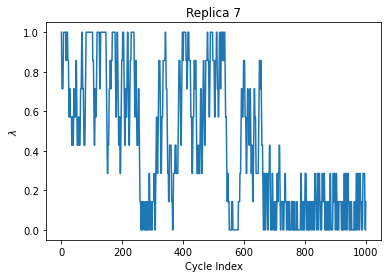

In [5]:
import numpy as np
import matplotlib.pyplot as plt
i=7
fn='aa'+str(i)+'/his/cond_his1.dat'
l=np.loadtxt(fn)
plt.xlabel('Cycle Index')
plt.ylabel('$\lambda$')
plt.title('Replica '+str(i))
plt.plot(l[:,0],l[:,1])


### Free energy profile ```fe_fn``` (mbar.out here): the 1st column is $\lambda$; the 2nd column is free energy, and the 3rd column is the error bar

In [6]:
!cat mbar.out

0.000000 0.000000 0.000000
0.142900 1.479907 0.011935
0.285700 2.395354 0.033028
0.428600 2.135361 0.054101
0.571400 1.230241 0.061366
0.714300 0.022864 0.065439
0.857100 -1.496388 0.067177
1.000000 -3.556602 0.070945
